# 01_Setup_&_EDA.ipynb

**Project:** Reducing Hallucinations via Verifier-Reranking

**Author:** Ryan Powers

## Purpose
This notebook establishes the computational environment and experimental configuration for the project.
1.  **Environment Setup:** Mounts Google Drive and installs pinned dependencies.
2.  **Configuration:** Generates the `baseline.json` artifact, acting as the "Source of Truth" for all hyperparameters (seeds, model names, token limits).
3.  **Exploratory Data Analysis (EDA):** analyzes the CNN/DailyMail dataset to determine optimal source/target token lengths.

In [3]:
# Environment Setup


import sys
import os

print("Installing Project Dependencies")
!pip install -q \
    evaluate==0.4.2 \
    rouge_score==0.1.2 \
    bert_score==0.3.13 \
    orjson==3.10.1 \
    rich==13.7.1 \
    typer==0.12.3 \
    matplotlib \
    seaborn

# Log versions for reproducibility
import torch
import transformers
import pandas as pd
import numpy as np

print(f"\n--- Environment Version Log ---")
print(f"Python: {sys.version.split()[0]}")
print(f"PyTorch: {torch.__version__}")
print(f"Transformers: {transformers.__version__}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

Installing Project Dependencies
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.8 MB/s eta 0:00:00

--- Environment Version Log ---
Python: 3.12.12
PyTorch: 2.9.0+cu126
Transformers: 4.57.2
GPU: NVIDIA L4


## Experiment Configuration
Pin point a central configuration dictionary (`cfg`) and save it as `baseline.json`.
This ensures that Training (Notebook 02), Generation (Notebook 03), and Scoring (Notebook 04) all share identical settings for reproducibility.

In [ ]:

import os
import json
import random
import time
import pathlib
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import set_seed
import nltk
from google.colab import drive

#  Mounting Google Drive
drive.mount('/content/drive')

# Defining  Project Paths
# "Home Base"
BASE_DIR = "/content/drive/MyDrive/w266_project_final"
DATA_DIR = os.path.join(BASE_DIR, "data")
MODELS_DIR = os.path.join(BASE_DIR, "models")
OUTPUTS_DIR = os.path.join(BASE_DIR, "outputs")
CONFIGS_DIR = os.path.join(BASE_DIR, "configs")
TABLES_DIR = os.path.join(BASE_DIR, "tables")
FIGS_DIR = os.path.join(BASE_DIR, "figs")
HF_CACHE_DIR = os.path.join(DATA_DIR, "hf_cache")

# All directories
for d in [DATA_DIR, MODELS_DIR, OUTPUTS_DIR, CONFIGS_DIR, TABLES_DIR, FIGS_DIR, HF_CACHE_DIR]:
    os.makedirs(d, exist_ok=True)

# Setting HF cache to project dir
os.environ["HF_HOME"] = HF_CACHE_DIR
print(f"Base project directory set to: {BASE_DIR}")

# Global Config & Seeding == 42
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
print(f"Global random seed set to {SEED}.")

# Create Central Config File
# This is the "source of truth" for all experiments
cfg = {
    "model_name": "facebook/bart-base",
    "dataset_name": "cnn_dailymail",
    "dataset_config": "3.0.0",
    "train_subset_size": 20000, #20k subsample
    "val_subset_size": 2000,
    "seed": SEED,
    "text_fields": {"source": "article", "summary": "highlights"},

    "tokenization": {
        "max_source_len": 1024,
        "max_target_len": 128
    },

    "train": {
        "output_dir": os.path.join(MODELS_DIR, "bart_base_cnn_dm_20k"),
        "epochs": 3,
        "batch_size": 8,
        "grad_accum": 2,
        "lr": 5e-5,
        "warmup_ratio": 0.03
    },
    "generate": {
        "num_beams": 5,
        "num_return_sequences": 5,
        "max_new_tokens": 128,
        "min_new_tokens": 10
    },
    "verifier": {
        "hf_id": "manueldeprada/FactCC",
        "correct_label_id": 1,
        "chunk_size": 350
    }
}

CONFIG_PATH = os.path.join(CONFIGS_DIR, "baseline.json")
with open(CONFIG_PATH, 'w') as f:
    json.dump(cfg, f, indent=2)

print(f"All directories created.")
print(f"Baseline config artifact UPDATED and saved to {CONFIG_PATH}")



Mounted at /content/drive
Base project directory set to: /content/drive/MyDrive/w266_project_final
Global random seed set to 42.
All directories created.
Baseline config artifact UPDATED and saved to /content/drive/MyDrive/w266_project_final/configs/baseline.json


In [ ]:
# EDA - Loading Dataset and Verifying Splits (Guardrail #1)

print(f"Loading {cfg['dataset_name']} (config {cfg['dataset_config']})...")

ds = load_dataset(
    cfg["dataset_name"],
    cfg["dataset_config"],
    cache_dir=HF_CACHE_DIR
)

print("\n--- Dataset Splits (Size) ---")
print(f"Train:      {len(ds['train'])} examples")
print(f"Validation: {len(ds['validation'])} examples")
print(f"Test:       {len(ds['test'])} examples")

Loading cnn_dailymail (config 3.0.0)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]


--- Dataset Splits (Size) ---
Train:      287113 examples
Validation: 13368 examples
Test:       11490 examples


## 3.0: Exploratory Data Analysis (EDA)
**Goal:** Determine optimal `max_source_length` and `max_target_length`.
Analyze the distribution of token counts in the Training set.
* **Article Length:** Most articles fall under 1000 tokens. Selected **1024** to minimize truncation loss.
* **Summary Length:** Most highlights are under 100 tokens. Selected **128** to ensure complete generation.

## 4.0: Token Length Analysis (Justification for Hyperparameters)

**Purpose:** In the distribution of word counts in a random sample ($N=10,000$) of the training set to determine appropriate truncation limits for the model.

**Observations:**
* **Article Length:** The mean length is **692 words** (approx. 900 tokens). The 75th percentile is **877 words**.
    * *Decision:* Setting `max_source_length = 1024` covers the vast majority of articles without truncation, ensuring the model has access to the full context.
* **Summary Length:** The mean length is **51 words**. The max is **421**, but the 75th percentile is only **59**.
    * *Decision:* Setting `max_target_length = 128` is sufficient for generation while preventing runaway decoding.

**Conclusion:** The hyperparameters defined in `baseline.json` (`1024` / `128`) is my attempt to justify by the data distribution.

Calculating text lengths (using a 10k *random* sample)...

--- Length Statistics (Word Count, 10k Random Sample) ---
       article_length_words  highlights_length_words
count          10000.000000              10000.00000
mean             691.938400                 51.19320
std              336.050184                 20.41077
min               37.000000                  6.00000
25%              443.750000                 38.00000
50%              633.000000                 48.00000
75%              877.000000                 59.00000
max             1967.000000                421.00000


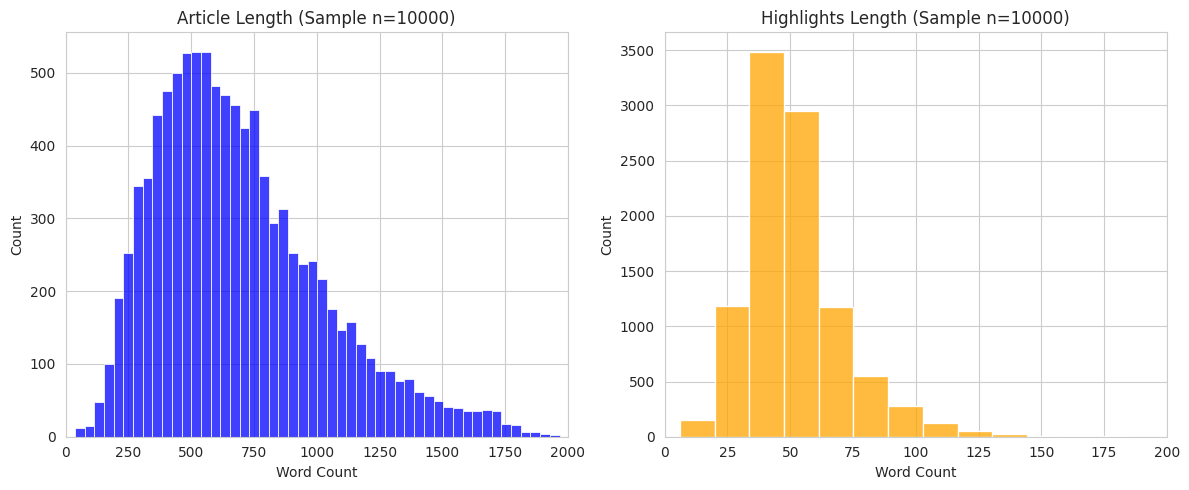

In [ ]:
# EDA - Text Length Analysis

print("Calculating text lengths (using a 10k *random* sample)...")
nltk.download('punkt', quiet=True)

# Shuffling
EDA_SAMPLE_SIZE = 10000
train_df_shuffled = ds['train'].shuffle(seed=SEED)
df_sample = pd.DataFrame(train_df_shuffled.select(range(EDA_SAMPLE_SIZE)))


df_sample['article_length_words'] = df_sample['article'].apply(lambda x: len(x.split()))
df_sample['highlights_length_words'] = df_sample['highlights'].apply(lambda x: len(x.split()))

print("\n--- Length Statistics (Word Count, 10k Random Sample) ---")
print(df_sample[['article_length_words', 'highlights_length_words']].describe())

#Visualize Distributions
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")
plt.subplot(1, 2, 1)
sns.histplot(df_sample['article_length_words'], bins=50, color='blue', kde=False)
plt.title(f'Article Length (Sample n={EDA_SAMPLE_SIZE})')
plt.xlabel('Word Count')
plt.xlim(0, 2000)
plt.subplot(1, 2, 2)
sns.histplot(df_sample['highlights_length_words'], bins=30, color='orange', kde=False)
plt.title(f'Highlights Length (Sample n={EDA_SAMPLE_SIZE})')
plt.xlabel('Word Count')
plt.xlim(0, 200)
plt.tight_layout()
plt.show()

